## Skeleton Code

The code below provides a skeleton for the model building & training component of your project. You can add/remove/build on code however you see fit, this is meant as a starting point.

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from glob import glob
%matplotlib inline
import matplotlib.pyplot as plt

##Import any other stats/DL/ML packages you may need here. E.g. Keras, scikit-learn, etc.
from itertools import chain
from random import sample 
from collections import Counter
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.models import Sequential, Model
from keras.optimizers import Adam
from sklearn.model_selection import KFold
from keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score, plot_precision_recall_curve, f1_score, confusion_matrix

Using TensorFlow backend.


## Do some early processing of your metadata for easier model training:

In [2]:
## Below is some helper code to read all of your full image filepaths into a dataframe for easier manipulation
## Load the NIH data to all_xray_df
all_xray_df = pd.read_csv('/data/Data_Entry_2017.csv')
all_image_paths = {os.path.basename(x): x for x in 
                   glob(os.path.join('/data','images*', '*', '*.png'))}
print('Scans found:', len(all_image_paths), ', Total Headers', all_xray_df.shape[0])
all_xray_df['path'] = all_xray_df['Image Index'].map(all_image_paths.get)
all_xray_df.sample(3)

Scans found: 112120 , Total Headers 112120


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11,path
31405,00008198_004.png,No Finding,4,8198,28,M,AP,2500,2048,0.168,0.168,NaN,/data/images_004/images/00008198_004.png
70173,00017275_002.png,Pneumothorax,2,17275,53,M,PA,2992,2991,0.143,0.143,NaN,/data/images_008/images/00017275_002.png
99170,00026222_011.png,Emphysema|Pneumothorax,11,26222,52,M,PA,2992,2991,0.143,0.143,NaN,/data/images_011/images/00026222_011.png


In [3]:
# Clean The Dataframe
df = all_xray_df.copy()
df.columns = df.columns.str.replace(' ', '_')
OriginalImageWidth = df.iloc[: , 7]
OriginalImageHeight = df.iloc[: , 8]
OriginalImagePixelSpacing_x = df.iloc[: , 9]
OriginalImagePixelSpacing_y = df.iloc[: , 9]
df = df.iloc[:,0:7]
df['OriginalImageWidth'] = list(OriginalImageWidth) 
df['OriginalImageHeight'] = list(OriginalImageHeight) 
df['OriginalImagePixelSpacing_x'] = list(OriginalImagePixelSpacing_x) 
df['OriginalImagePixelSpacing_y'] = list(OriginalImagePixelSpacing_y) 
df['path'] = all_xray_df['Image Index'].map(all_image_paths.get)
df.head(1)

,Image_Index,Finding_Labels,Follow-up_#,Patient_ID,Patient_Age,Patient_Gender,View_Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,OriginalImagePixelSpacing_y,path
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,0.143,/data/images_001/images/00000001_000.png


In [4]:
## One Hot Encoding of the Finding Labels Column
all_labels = np.unique(list(chain(*df['Finding_Labels'].map(lambda x: x.split('|')).tolist())))
all_labels = [x for x in all_labels if len(x)>0]
for c_label in all_labels:
    if len(c_label)>1: # leave out empty labels
        df[c_label] = df['Finding_Labels'].map(lambda finding: 1 if c_label in finding else 0)

del df['Finding_Labels']
df.columns = df.columns.str.replace(' ', '_')

df.head(1)

,Image_Index,Follow-up_#,Patient_ID,Patient_Age,Patient_Gender,View_Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,OriginalImagePixelSpacing_y,...,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No_Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
0,00000001_000.png,0,1,58,M,PA,2682,2749,0.143,0.143,...,0,0,0,0,0,0,0,0,0,0


In [5]:
pneumonia_classes = filter(None, df['Pneumonia'] == 1)
print('Pneumonia cases:', len(list(pneumonia_classes)))

Pneumonia cases: 1431


## Create your training and testing data:

In [6]:
def create_splits(df, test_size, classToPredict):
    train_data, val_data = train_test_split(df,  test_size = test_size, stratify = df[classToPredict])
    return train_data, val_data

In [7]:
train_df, val_df = create_splits(df, 0.2, 'Pneumonia')

print("train_df", train_df.shape)
print("val_df", val_df.shape)

train_df (89696, 26)
val_df (22424, 26)


In [8]:
# Check the distribution of pneumonia cases in the test and validation set
print("train", train_df['Pneumonia'].sum()/len(train_df))
print("validation", val_df['Pneumonia'].sum()/len(val_df))

train 0.012765340706386016
validation 0.012754191937210132


In [9]:
# Get a balanced dataset (50/50) = equal amount of positive and negative cases in Training
p_inds = train_df[train_df.Pneumonia==1].index.tolist()
np_inds = train_df[train_df.Pneumonia==0].index.tolist()

np_sample = sample(np_inds,len(p_inds))
train_df = train_df.loc[p_inds + np_sample]
print("train", train_df['Pneumonia'].sum()/len(train_df))

train 0.5


In [10]:
# Get a validation set with at 20% Pneumonia cases
p_inds = val_df[val_df.Pneumonia==1].index.tolist()
np_inds = val_df[val_df.Pneumonia==0].index.tolist()

np_sample = sample(np_inds,4*len(p_inds))
val_df = val_df.loc[p_inds + np_sample]
print("validation", val_df['Pneumonia'].sum()/len(val_df))

validation 0.2


# Now we can begin our model-building & training

#### First suggestion: perform some image augmentation on your data

In [11]:
# define globals
IMG_SIZE = (224, 224)
BATCH_SIZE = 64

def image_augmentation():    
    ## STAND-OUT SUGGESTION: implement some of your own custom augmentation that's *not*
    ## built into something like a Keras package
    
    # create the generator
    # horizontal_flip and vertical_flip should be set to True/False
    # height_shift_range and width_shift_range should be between 0 and 1
    # rotation_range can be between 0 and 180
    # shear_range can be between 0 and 1
    # zoom_range can be between 0 and 1
    idg = ImageDataGenerator(rescale = 1 / 255.0,
                             horizontal_flip = True, 
                             vertical_flip = False, 
                             height_shift_range = 0.1, 
                             width_shift_range = 0.1, 
                             rotation_range = 25, 
                             shear_range = 0.1,
                             zoom_range = 0.15)
    return idg

def make_train_gen(idg, df):
    train_gen = idg.flow_from_dataframe(dataframe=df, 
                                           directory = None, 
                                           x_col = 'path',
                                           y_col = 'Pneumonia',
                                           class_mode = 'raw',
                                           target_size = IMG_SIZE, 
                                           batch_size = BATCH_SIZE
                                         )
    return train_gen


def make_val_gen(valid_df):
    val_idg = ImageDataGenerator(rescale=1. / 255.0)
    val_gen = val_idg.flow_from_dataframe(dataframe=valid_df, 
                                            directory=None, 
                                            x_col = 'path',
                                            y_col = 'Pneumonia',
                                            class_mode = 'raw',
                                            shuffle = False,
                                            target_size = IMG_SIZE, 
                                            batch_size = BATCH_SIZE) 
    return val_gen

In [12]:
## May want to pull a single large batch of random validation data for testing after each epoch:
val_gen = make_val_gen(val_df)
valX, valY = val_gen.next()

Found 1430 validated image filenames.


Found 2290 validated image filenames.


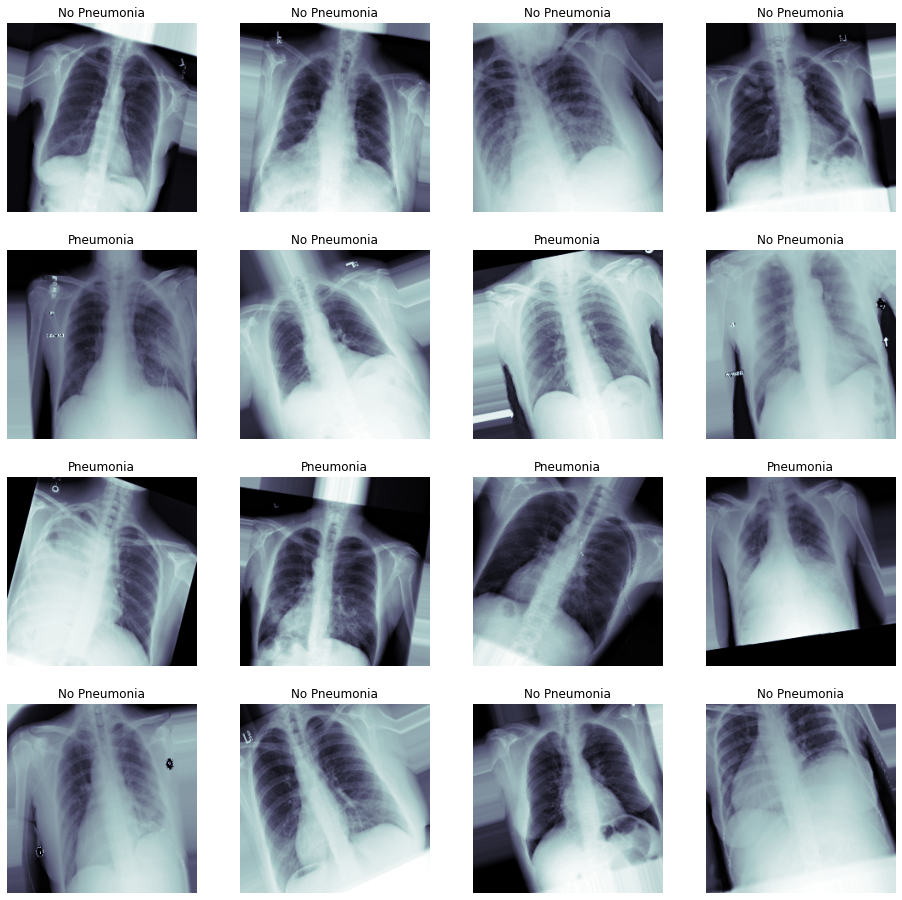

In [13]:
## May want to look at some examples of our augmented training data. 
## This is helpful for understanding the extent to which data is being manipulated prior to training, 
## and can be compared with how the raw data look prior to augmentation
imageDataGenerator = image_augmentation()
train_gen = make_train_gen(imageDataGenerator, train_df)

t_x, t_y = next(train_gen)
fig, m_axs = plt.subplots(4, 4, figsize = (16, 16))
for (c_x, c_y, c_ax) in zip(t_x, t_y, m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone')
    if c_y == 1: 
        c_ax.set_title('Pneumonia')
    else:
        c_ax.set_title('No Pneumonia')
    c_ax.axis('off')

## Build your model: 

Recommendation here to use a pre-trained network downloaded from Keras for fine-tuning

In [14]:
def load_pretrained_model(layer_of_interest = "block5_pool"):
    
    model = VGG16(include_top=True, weights='imagenet')
    transfer_layer = model.get_layer(layer_of_interest)
    vgg_model = Model(inputs = model.input, outputs = transfer_layer.output)
    
    for layer in vgg_model.layers[0:17]:
        layer.trainable = False
    
    return vgg_model

In [15]:
def build_my_model():
    
    model = Sequential()

    # add your pre-trained model, 
    model.add(load_pretrained_model())

    # additional layers   
    model.add(Flatten())
    model.add(Dropout(0.50))
    
    model.add(Dense(1024, activation='relu'))
    model.add(Dropout(0.30))
    
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.25))
    
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.20))
    
    model.add(Dense(1, activation='sigmoid'))
    return model

In [16]:
my_model = build_my_model()
my_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_1 (Model)              (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 25088)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              25691136  
_________________________________________________________________
dropout_2 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               524800    
_________________________________________________________________
dropout_3 (Dropout)          (None, 512)              

In [17]:
## Set optimizer, loss function, and learning rate
epochs = 100
learning_rate = 1e-4
optimizer = Adam(lr=learning_rate)
loss = 'binary_crossentropy'
metrics = ['accuracy']

my_model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

In [18]:
## Below is some helper code that will allow you to add checkpoints to your model,
## This will save the 'best' version of your model by comparing it to previous epochs of training

## Note that you need to choose which metric to monitor for your model's 'best' performance if using this code. 
## The 'patience' parameter is set to 10, meaning that your model will train for ten epochs without seeing
## improvement before quitting

weight_path="{}_my_model.best.hdf5".format('xray_class')

checkpoint = ModelCheckpoint(weight_path, 
                             monitor = 'val_loss', 
                             verbose = 1, 
                             save_best_only = True, 
                             mode = 'auto', 
                             save_weights_only = True)

early = EarlyStopping(monitor = 'val_loss', 
                      mode = 'auto', 
                      patience = 10)

callbacks_list = [checkpoint, early]

### Start training! 

In [19]:
## train the model
history = my_model.fit(train_gen, 
                      validation_data = (valX, valY), 
                      epochs = epochs, 
                      callbacks = callbacks_list,
                      verbose = 1)

Epoch 1/100
36/36 [==============================] - 63s 2s/step - loss: 0.7446 - accuracy: 0.5114 - val_loss: 0.7640 - val_accuracy: 0.3594

Epoch 00001: val_loss improved from inf to 0.76398, saving model to xray_class_my_model.best.hdf5
Epoch 2/100
36/36 [==============================] - 59s 2s/step - loss: 0.6976 - accuracy: 0.5546 - val_loss: 0.9697 - val_accuracy: 0.0000e+00

Epoch 00002: val_loss did not improve from 0.76398
Epoch 3/100
36/36 [==============================] - 59s 2s/step - loss: 0.6916 - accuracy: 0.5624 - val_loss: 0.7636 - val_accuracy: 0.3906

Epoch 00003: val_loss improved from 0.76398 to 0.76362, saving model to xray_class_my_model.best.hdf5
Epoch 4/100
36/36 [==============================] - 60s 2s/step - loss: 0.6844 - accuracy: 0.5620 - val_loss: 0.6048 - val_accuracy: 0.7344

Epoch 00004: val_loss improved from 0.76362 to 0.60484, saving model to xray_class_my_model.best.hdf5
Epoch 5/100
36/36 [==============================] - 60s 2s/step - loss: 0.

##### After training for some time, look at the performance of your model by plotting some performance statistics:

Note, these figures will come in handy for your FDA documentation later in the project

In [20]:
## After training, make some predictions to assess your model's overall performance
## Note that detecting pneumonia is hard even for trained expert radiologists, 
## so there is no need to make the model perfect.
my_model.load_weights(weight_path)
val_Y = val_df['Pneumonia']
pred_Y = my_model.predict(val_gen, verbose = True)

23/23 [==============================] - 26s 1s/step


In [21]:
# function to plot the roc_curve
def plot_auc(t_y, p_y):
    fpr, tpr, thresholds = roc_curve(t_y, p_y, pos_label=1)
    fig, c_ax = plt.subplots(1,1, figsize = (9, 9))
    c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % ('Pneumonia', auc(fpr, tpr)))
    c_ax.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
    c_ax.legend()
    c_ax.set_xlabel('False Positive Rate')
    c_ax.set_ylabel('True Positive Rate')

# function to plot the precision_recall_curve. You can utilizat precision_recall_curve imported above
def plot_precision_recall_curve_helper(t_y, p_y):
    fig, c_ax = plt.subplots(1,1, figsize = (9, 9))
    precision, recall, thresholds = precision_recall_curve(t_y, p_y, pos_label=1)
    aps = average_precision_score(t_y, p_y)
    c_ax.plot(recall, precision, label = '%s (AP Score:%0.2f)'  % ('Pneumonia', aps))
    c_ax.plot(recall, precision, color='red', lw=2)
    c_ax.legend()
    c_ax.set_xlabel('Recall')
    c_ax.set_ylabel('Precision')
    

# function to plot the history
def plot_history(history):
    f = plt.figure()
    f.set_figwidth(15)
    
    f.add_subplot(1, 2, 1)
    plt.plot(history.history['val_loss'], label='val loss')
    plt.plot(history.history['loss'], label='train loss')
    plt.legend()
    plt.title("Modell Loss")
    
    f.add_subplot(1, 2, 2)
    plt.plot(history.history['val_accuracy'], label='val accuracy')
    plt.plot(history.history['accuracy'], label='train accuracy')
    plt.legend()
    plt.title("Modell Accuracy")

    plt.show()

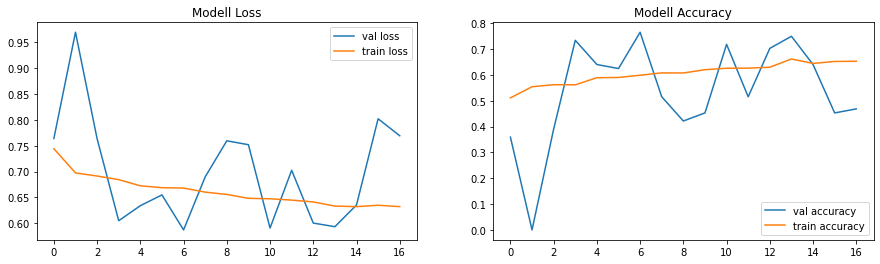

In [22]:
hist = plot_history(history)

Once you feel you are done training, you'll need to decide the proper classification threshold that optimizes your model's performance for a given metric (e.g. accuracy, F1, precision, etc.  You decide) 

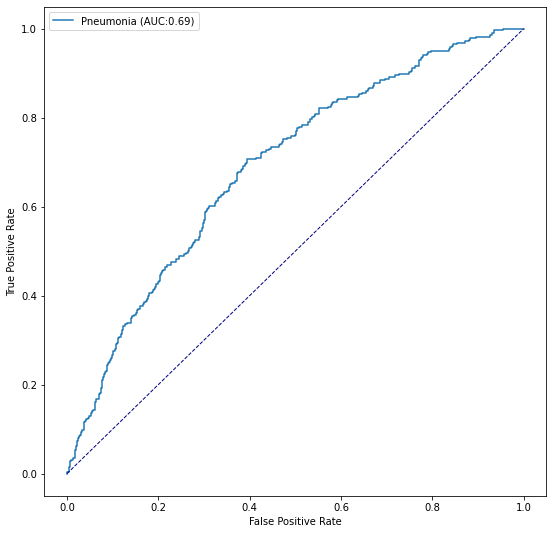

In [23]:
plot_auc(val_Y, pred_Y)

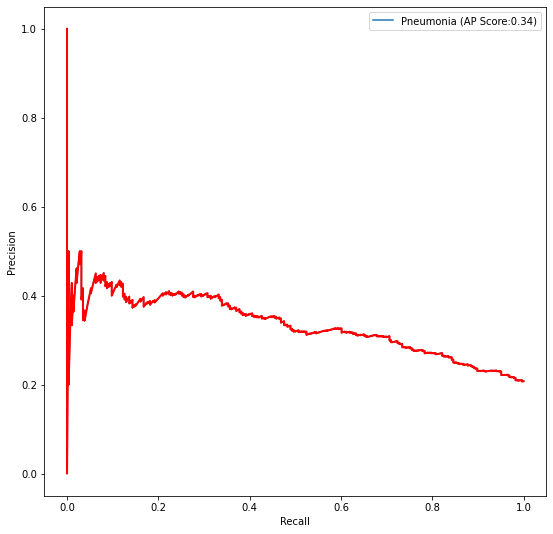

In [24]:
plot_precision_recall_curve_helper(val_Y, pred_Y)

In [25]:
## Find the threshold that optimize your model's performance,
## and use that threshold to make binary classification. Make sure you take all your metrics into consideration.

def calc_f1(prec,recall):
    return 2*(prec*recall)/(prec+recall) if recall and prec else 0

precision, recall, thresholds = precision_recall_curve(val_Y, pred_Y)
f1score = [calc_f1(precision[i],recall[i]) for i in range(len(thresholds))]
idx = np.argmax(f1score)
threshold = thresholds[idx]

print('Precision: '+ str(precision[idx]))
print('Recall: '+ str(recall[idx]))
print('Threshold: '+ str(thresholds[idx]))
print('F1 Score: ' + str(f1score[idx]))

Precision: 0.308868501529052
Recall: 0.7062937062937062
Threshold: 0.5215164
F1 Score: 0.4297872340425532


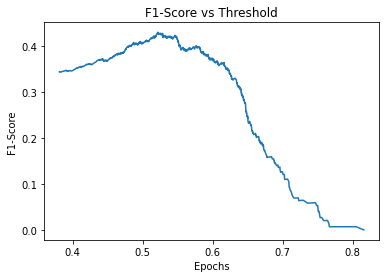

In [26]:
plt.figure()
plt.plot(thresholds, f1score)
plt.title("F1-Score vs Threshold")
plt.xlabel("Epochs")
plt.ylabel("F1-Score")
plt.show()

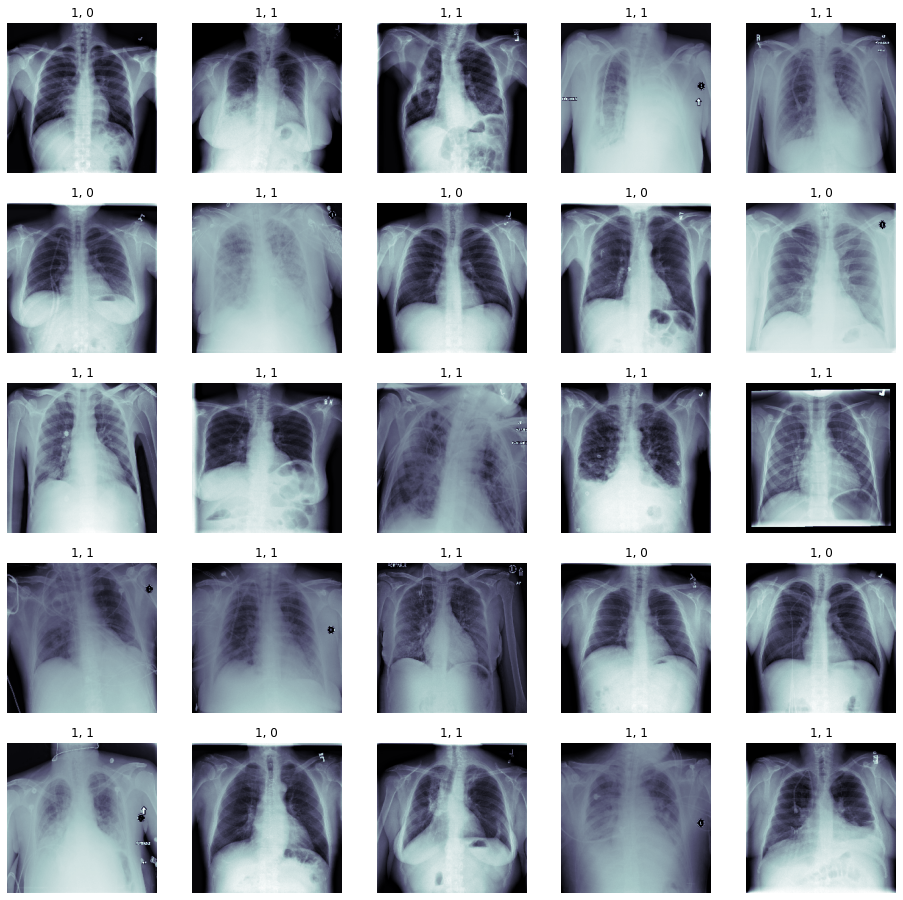

In [27]:
## Let's look at some examples of true vs. predicted with our best model: 
fig, m_axs = plt.subplots(5, 5, figsize = (16, 16))
i = 0
for (c_x, c_y, c_ax) in zip(valX[0:25], valY[0:25], m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone')
    if c_y == 1: 
        if pred_Y[i] > threshold :
            c_ax.set_title('1, 1')
        else:
            c_ax.set_title('1, 0')
    else:
        if pred_Y[i] > threshold : 
            c_ax.set_title('0, 1')
        else:
            c_ax.set_title('0, 0')
    c_ax.axis('off')
    i=i+1

In [28]:
## Just save model architecture to a .json:
model_json = my_model.to_json()
with open("my_model.json", "w") as json_file:
    json_file.write(model_json)